# Hash Sample

This is the notebook of generating the samples of hash matching for annotating.

In [1]:
import mongoengine
from mongoengine import *
from mongoengine.queryset.visitor import Q
from dbmodels import *
from hashfunction import *
from readref import *

import pandas as pd
from bson.objectid import ObjectId
import configparser
from multiprocessing import Pool
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set('notebook')

In [2]:
# Read the confidentials.
credentials = configparser.ConfigParser()
credentials.read('credentials.ini')

# Connect to the database.
connect(
    db = credentials.get('lb', 'db'),
    username = credentials.get('lb', 'username'),
    password = credentials.get('lb', 'password'),
    host = credentials.get('lb', 'host'), 
    port = int(credentials.get('lb', 'port')), 
);

## Black List

Generate the Hash Black list.

In [8]:
# read the distribution of all returned references for each hash
df_stat = pd.read_pickle('./pickle/hash_stat.pickle')
df_stat['k_group'] = df_stat['counts'].apply(lambda x: (x//1000))
df_stat['h_group'] = df_stat['counts'].apply(lambda x: (x//100))
df_stat['t_group'] = df_stat['counts'].apply(lambda x: (x//10))
df_stat['d_group'] = df_stat['counts'].apply(lambda x: (x//1))
df_stat.head()

,counts,k_group,h_group,t_group,d_group
hashtag,,,,,
repubblica#venezia,6508,6,65,650,6508
san#marco,4759,4,47,475,4759
storia#venezia,4671,4,46,467,4671
atti#convegno,4603,4,46,460,4603
cura#1985,3684,3,36,368,3684


Have a look at the hashes with a great many returned references.

In [9]:
hash_1000 = df_stat[df_stat.k_group>0].index.values
hash_1000.sort()
hash_1000

array(['archivio#veneto', 'arte#veneta', 'atti#convegno',
       'biografico#italiani', 'caduta#repubblica', 'catalogo#mostra',
       'citta#nobilissima', 'citta#venezia', 'civilta#veneziana',
       'convegno#internazionale', 'cozzi#repubblica#venezia',
       'cultura#veneta', 'cura#1956', 'cura#1957', 'cura#1958',
       'cura#1959', 'cura#1960', 'cura#1961', 'cura#1962', 'cura#1963',
       'cura#1964', 'cura#1965', 'cura#1966', 'cura#1967', 'cura#1968',
       'cura#1969', 'cura#1970', 'cura#1971', 'cura#1972', 'cura#1973',
       'cura#1974', 'cura#1975', 'cura#1976', 'cura#1977', 'cura#1978',
       'cura#1979', 'cura#1980', 'cura#1981', 'cura#1982', 'cura#1983',
       'cura#1984', 'cura#1985', 'cura#1986', 'cura#1987', 'cura#1988',
       'cura#1989', 'cura#1990', 'cura#1991', 'cura#1992', 'cura#1993',
       'cura#1994', 'cura#1995', 'cura#1996', 'cura#1997', 'cura#1998',
       'cura#1999', 'cura#2000', 'cura#2001', 'cura#2002', 'cura#2003',
       'cura#2004', 'cura#2005',

In [10]:
hash_500 = df_stat[(df_stat.counts<1000) & (df_stat.h_group>=5)].index.values
hash_500.sort()
hash_500

array(['alto#medioevo', 'ambasciatori#veneti', 'andrea#palladio',
       'architettura#scultura', 'archivio#stato', 'archivio#storico',
       'arnaldi#cultura#veneta', 'arnaldi#storia#cultura',
       'arte#italiana', 'aspetti#problemi', 'ateneo#veneto',
       'atti#congresso', 'atti#istituto', 'basilica#san', 'belle#arti',
       'beltrami#1955', 'caduta#serenissima', 'canal#grande',
       'cenni#storici', 'century#venice', 'cessi#repubblica#venezia',
       'chiesa#san', 'chiesa#venezia', 'cinque#seicento',
       'comune#venezia', 'concilio#trento', 'convegno#intemazionale',
       'convegno#studi', 'corner#1748', 'corner#1749', 'corner#1750',
       'cozzi#1981', 'cozzi#1985', 'cozzi#1986', 'cozzi#1993',
       'cura#1913', 'cura#1939', 'cura#1941', 'cura#1942', 'cura#1954',
       'cura#1955', 'cura#2008', 'cura#2009', 'cura#2010',
       'cura#convegno#internazionale', 'cura#cultura#veneta',
       'cura#eta#moderna', 'cura#repubblica#venezia',
       'cura#storia#cultura', 'c

Remove some hashes because of the error.

In [11]:
hash_cura = [h for h in df_stat.index.values if h.startswith('cura#')]

Add back some white hashes.

In [12]:
hash_white = ['cozzi#repubblica#venezia', 'sansovino#citta#nobilissima',
              'citta#nobilissima', 'beltrami#1955', 'corner#1748', 'corner#1749', 'corner#1750',
              'cozzi#1981', 'cozzi#1985', 'cozzi#1986', 'cozzi#1993',
              'hale#1972', 'hale#1973', 'hale#1974', 'hale#renaissance#venice',
              'luzzatto#1962', 'luzzatto#storia#economica',
              'cessi#repubblica#venezia',
              'molmenti#storia#venezia', 'molmenti#venezia#vita',
              'molmenti#vita#privata',
              'pastore#cultura#veneta',
              'pastore#storia#cultura',
              'romanin#documentata#venezia',
              'romanin#storia#documentata',
              'sansovino#nobilissima#singolare',
              'stocchi#cultura#veneta', 'stocchi#storia#cultura',
              'tenenti#storia#venezia']

Get the black list.

In [15]:
hash_black = list(set(hash_1000)|set(hash_500)|set(hash_cura)-set(hash_white))

In [22]:
# save
s = pd.Series(hash_black)
s.to_pickle('hash_black.pickle')

## Match

Preforming the hash matching

In [6]:
hash_black = set(pd.read_pickle('hash_black.pickle').values)

In [3]:
s_1 = pd.read_pickle('./pickle/hash_match1.pickle')
s_2 = pd.read_pickle('./pickle/hash_match2.pickle')
s_3 = pd.read_pickle('./pickle/hash_match3.pickle')
s_4 = pd.read_pickle('./pickle/hash_match4.pickle')

In [4]:
df_1 = pd.read_pickle("./pickle/hash_ref1.pickle")
df_2 = pd.read_pickle("./pickle/hash_ref2.pickle")
df_3 = pd.read_pickle("./pickle/hash_ref3.pickle")
df_4 = pd.read_pickle("./pickle/hash_ref4.pickle")

In [7]:
def find_match(record):
    hashes_all = record.hashes
    hashes = list(set(hashes_all)-hash_black) # remove hashes in black list
    set_result = set()
    for s in [s_1, s_2, s_3, s_4]:
        r = [r for rs in s.reindex(hashes).dropna().values for r in rs]
        r = set(r)
        set_result = set_result.union(r) 
    return list(set_result)

In [25]:
for i, df in enumerate([df_1, df_2, df_3, df_4]):
    print(i)
    df['match'] = df.apply(find_match, axis=1)
    print('store!')
    df.to_pickle('./pickle/hash_ref{}.pickle'.format(i+1))

0
store!
1
store!
2
store!
3
store!


In [94]:
df_all = pd.concat([df_1, df_2, df_3, df_4])

In [96]:
df_all = df_all[['ref_id','doc_id', 'surface']]

In [98]:
df_all.to_pickle('./pickle/ref_doc_surface.pickle')

In [100]:
df_all = df_all.set_index('ref_id')

Remove the references that are in the same document.

In [124]:
def remove_same_doc(record):
    match = record.match
    doc_id = record.doc_id
    ref_same_doc = df_all[df_all.doc_id==doc_id].index.values
    return list(set(match)-set(ref_same_doc))

In [ ]:
for i, df in enumerate([df_2, df_3, df_4]):
    print(i)
    df['new_match'] = df.apply(remove_same_doc, axis=1)
    df.drop(columns='match', inplace=True)
    print('store!')
    df.to_pickle('./pickle/hash_ref{}.pickle'.format(i+2))

## Match Stat

Analyzing the mathcing results

In [7]:
def number_level(n):
    if n//1000>0:
        return '1000+'
    if n//500>0:
        return '500+'
    if n//200>0:
        return '200+'
    if n//100>0:
        return '100+'
    if n//50>0:
        return '50+'
    if n//20>0:
        return '20+'
    if n//10>0:
        return '10+'
    if n==1:
        return '1'
    if n==0:
        return '0'
    return '1+'

In [8]:
level = ['1000+', '500+', '200+', '100+', '50+', '20+', '10+', '1+', '1', '0']

**After removing refs in the same document**

In [5]:
df_1 = pd.read_pickle("./pickle/hash_ref1.pickle")

In [9]:
df_1['len'] = df_1['new_match'].apply(len)

df_1['len'].describe()

count    117029.000000
mean        187.172820
std         247.739911
min           0.000000
25%          16.000000
50%          83.000000
75%         279.000000
max        3799.000000
Name: len, dtype: float64

In [10]:
df_1['len'].apply(number_level).value_counts()[level]

1000+     1620
500+     10978
200+     24922
100+     16828
50+      14399
20+      15922
10+       9205
1+       13680
1         3359
0         6116
Name: len, dtype: int64

In [15]:
len(df_1['len'].value_counts())

1634

In [36]:
len(df_1)+len(df_2)+len(df_3)+len(df_4)

495339

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc (zmq/backend/cython/message.c:4294)
KeyboardInterrupt


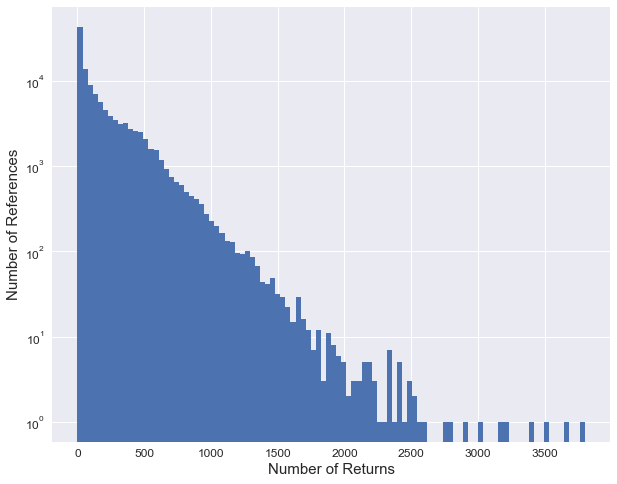

In [34]:
plt.figure(figsize=(10,8))
df_1['len'].plot('hist', bins=100, logy=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Number of Returns', fontsize=15)
plt.ylabel('Number of References', fontsize=15)
# plt.savefig('./fig/match_distribution.png');

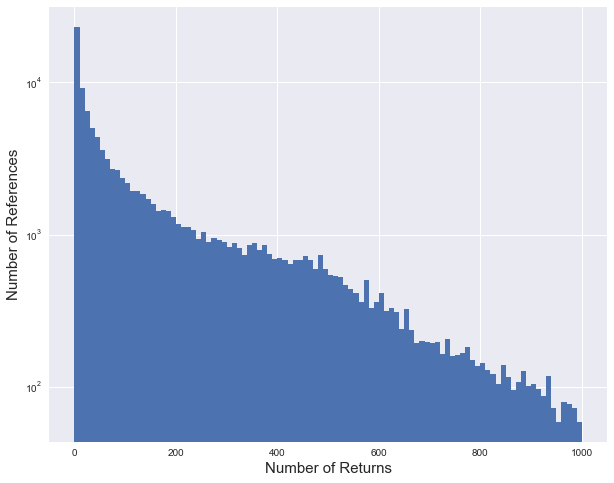

In [37]:
plt.figure(figsize=(10,8))
df_1[df_1['len']<=1000]['len'].plot('hist', bins=100, logy=True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Number of Returns', fontsize=15)
plt.ylabel('Number of References', fontsize=15)
# plt.savefig('./fig/match_distribution.png');

**Note:** Below is results before removing refs in the same document:

In [29]:
df_1['len'] = df_1['match'].apply(len)

df_1['len'].describe()

count    117029.000000
mean        190.157824
std         248.925953
min           1.000000
25%          18.000000
50%          86.000000
75%         283.000000
max        3822.000000
Name: len, dtype: float64

In [41]:
s_1 = df_1['len'].apply(number_level).value_counts()[level]
s_1

1000+     1656
500+     11230
200+     25050
100+     17110
50+      14820
20+      16448
10+       9814
1+       15877
1         5024
Name: len, dtype: int64

In [30]:
df_2['len'] = df_2['match'].apply(len)

df_2['len'].describe()

count    130925.000000
mean        233.295482
std         280.996598
min           0.000000
25%          29.000000
50%         125.000000
75%         356.000000
max        4760.000000
Name: len, dtype: float64

In [42]:
s_2 = df_2['len'].apply(number_level).value_counts()[level]
s_2

1000+     2962
500+     16209
200+     32586
100+     20053
50+      16282
20+      16734
10+       9403
1+       13427
1         3269
Name: len, dtype: int64

In [31]:
df_3['len'] = df_3['match'].apply(len)

df_3['len'].describe()

count    130800.000000
mean        244.277034
std         294.559303
min           0.000000
25%          33.000000
50%         135.000000
75%         368.000000
max       10768.000000
Name: len, dtype: float64

In [43]:
s_3 = df_3['len'].apply(number_level).value_counts()[level]
s_3

1000+     3334
500+     17198
200+     32956
100+     20205
50+      16218
20+      16662
10+       9111
1+       12337
1         2779
Name: len, dtype: int64

In [32]:
df_4['len'] = df_4['match'].apply(len)

df_4['len'].describe()

count    116585.000000
mean        226.718214
std         279.203267
min           1.000000
25%          27.000000
50%         119.000000
75%         342.000000
max        5455.000000
Name: len, dtype: float64

In [44]:
s_4 = df_4['len'].apply(number_level).value_counts()[level]
s_4

1000+     2516
500+     13847
200+     28245
100+     17886
50+      14720
20+      14951
10+       8465
1+       12781
1         3174
Name: len, dtype: int64

In [45]:
s_1 + s_2 + s_3 + s_4

1000+     10468
500+      58484
200+     118837
100+      75254
50+       62040
20+       64795
10+       36793
1+        54422
1         14246
Name: len, dtype: int64

## Select Seed Refs

In [154]:
def repr_return(doc_id):
    if doc_id==0: return 0
    a = Article.objects(id=doc_id).first()
    if a != None: return repr(a)
    b = Book.objects(id=doc_id).first()
    if b != None: return repr(b)
    return 0

In [84]:
repr(repr_return(df_0.loc[27].doc_id))

'<Article: "La facciata dell\'Ateneo e una opera ritrovata di Andrea dell\'Aquila" in "Ateneo veneto", 137(None) 1953, internal_id=RAV0164473:1953_137:8>'

### Zero match

In [111]:
# With zero match in other documents
df_0 = df_1[df_1.len==0][['doc_id', 'ref_id', 'surface']]

In [329]:
df_0_sample = df_0.loc[[24220, 74948, 51340, 91746, 96647, 76131, 71035, 100418, 13564, 43012]]
df_0_sample['doc_repr'] = df_0_sample['doc_id'].apply(repr_return)
df_0_sample = df_0_sample.set_index('ref_id')
df_0_sample = df_0_sample.reset_index()
df_0_sample = df_0_sample[['doc_id','doc_repr','ref_id','surface']]
df_0_sample.columns = [['seed_doc_id', 'seed_doc', 'seed_ref_id', 'seed_ref']]
df_0_sample['doc_id'] = None
df_0_sample['doc'] = None
df_0_sample['ref_id'] = None
df_0_sample['ref'] = None
df_0_sample

,seed_doc_id,seed_doc,seed_ref_id,seed_ref,doc_id,doc,ref_id,ref
0,595f9d6cfe7683316b2dce91,"<Article: ""Giacomo Casanova e Merlin Cocai Con...",58e4ce01fe7683152b57fcba,"Ricci, Figure e figuri del mondo teatrale, Mil...",None,None,None,None
1,595f9d2ffe7683316b2dc622,"<Book: Navis : l'umanesimo sul mare, 1470-1740...",5919e9663dde944752f57161,"Da E. Dummer, A Voyage into the Mediterranean ...",None,None,None,None
2,595fa072fe7683316b2de8ba,"<Article: "" Les marchands vénitiens à Constant...",58e4ce02fe7683152b5a958b,"Sacerdoti, Bembo, Marco, dans Dizionario Biogr...",None,None,None,None
3,595f9d35fe7683316b2dc662,<Book: Daniele Manin e la rivoluzione venezian...,5919e96d3dde944752f745be,"G. p. gooch (a cura di), Later Correspondence ...",None,None,None,None
4,59600cb6fe768357a5f6c02b,"<Book: Il Veneto nell'Alto Medioevo, Libreria...",59de7a1f48e232540c5b79b9,"Bettolini, Roma di fronte a Bisanzio e i Longo...",None,None,None,None
5,595f9d33fe7683316b2dc651,<Book: L'Austria a Venezia : società e istituz...,5919e9663dde944752f58fb4,"L. Carrer, Pagani Cesa, Giuseppe Urbano, Biogr...",None,None,None,None
6,595f9d2bfe7683316b2dc5f7,"<Book: Venezia e la Spagna, Banca cattolica d...",5919e9663dde944752f4fcb3,"J.A. Ceán Bermúdez, Diccionario histórico Je l...",None,None,None,None
7,59dc7571fe76834059d445dd,<Book: La comunità ebraica di Venezia e il suo...,59de7a1f48e232540c5bfc04,"Viterbo Ariel, v. Leone Da Modena, Vita dijehu...",None,None,None,None
8,595f9d53fe7683316b2dca31,"<Article: ""La biblioteca di Gerolamo Filago"" i...",58e4ce00fe7683152b56f0cc,"L. Gelasino de Fiesoli, Capitolo del gioco del...",None,None,None,None
9,595fa06cfe7683316b2de782,"<Article: ""Il ‘clan’ dei Foscari. Politica mat...",58e4ce01fe7683152b59ce76,"G. Zoccoletto, La contea dei Foscari a Zelarin...",None,None,None,None


In [330]:
df_0_sample.to_csv('./csv/0.csv', index=False)

---

In [141]:
df_all = pd.read_pickle('./pickle/ref_doc_surface.pickle')
df_all.set_index('ref_id', inplace=True) 

In [155]:
def generate_scv(df):
    for r in df.iterrows():
        record = r[1]
        # Information about seed
        seed_doc_id = record['doc_id']
        seed_doc = repr_return(seed_doc_id)
        seed_ref_id = record['ref_id']
        seed_ref = record['surface']
        # Match information
        match = record['new_match']
        d_list = []
        for m in match:
            ref_id = m
            ref = df_all.loc[m].surface
            doc_id = df_all.loc[m].doc_id
            doc = repr_return(doc_id)
            d = {
                'seed_doc_id': seed_doc_id,
                'seed_doc': seed_doc,
                'seed_ref_id': seed_ref_id,
                'seed_ref': seed_ref,
                'doc_id': doc_id,
                'doc': doc,
                'ref_id': ref_id,
                'ref': ref,
                'True': 0,
                'Hash': 1
            }
            d_list.append(d)
        df_r = pd.DataFrame.from_records(d_list)
        df_r = df_r[['seed_doc_id', 'seed_doc', 'seed_ref_id', 'seed_ref',
                     'doc_id', 'doc', 'ref_id', 'ref', 'True', 'Hash']]
        df_r.to_csv('./csv/{}_{}.csv'.format(record['len'], seed_ref_id), index=False)

### 1-10 match

In [306]:
df_10 = df_1[(df_1.len>0) & (df_1.len<10)]

In [308]:
index = [74727, 16720, 12544, 30713, 87072, 77051, 61584, 27682, 20104, 837]
df_10_sample = df_10.loc[index]

In [309]:
df_10_sample.surface.values

array(["L. Guerci, Libertà degli antichi e libertà dei moderni. Sparta, Atene e i « philosophes » nella Francia del '700, Napoli,\xa0Guida, 1979.",
       'M.G. MaiORINI, La Reggenza Borbonica (1759-1767), Napoli, 1991.',
       'L. Pupp ATI, Elogio a Francesco Trevisan, Padova 1850, pp. 13-15;',
       'J. Rousseau, L’Emile ou de l’éducation, II, Amsterdam 1762, pp. 167-168.',
       'D.\xa0Bellegarde, Histoire du peuple haitien, Losanna, 1954.',
       'V. Giuliani, Un tesoro nascosto ossia diario, a cura di P. Pizzicarla, I-III,\xa0Prato 1899.',
       'M. Valerii Probi in Virgilii Bucolica et Georgica Commentarius. Accedunt Scho- liorum Veronensium, et Aspri quaestionum Virgilianarum fragmen- ta, Halis , 1848,',
       'P. Tudebode, Historia de Hierosolymitano itinere, J.H. Hill and L.L. Hill, eds., Paris 1977, p. 131',
       'A. Catalano, Linee del sistema sovrannazìonale romano, I, Torino 1965, pp. 270-288;',
       "R. Paulson, Hogarth's Graphic Works: First Com- plete Edition,

In [310]:
generate_scv(df_10_sample)

### 1-100 match

In [404]:
df_100 = df_1[(df_1.len>=10) & (df_1.len<100)]

In [406]:
index = [91466, 31675, 10372, 78971, 77779, 89333, 46474, 75271, 3895, 64889]
df_100_sample = df_100.loc[index]

In [407]:
df_100_sample.surface.values

array(['A.ventura, La formazione intellettuale di Daniele Manin, in «Il Risorgimento», IX\xa0(1957).',
       'F. Di Maniago, Guida d’Udine in ciò che risguarda le tre belle Arti sorelle, San Vito (Pn) 1839, doc. III.',
       "BECKFORD, Dreams, 'Waking Thoughts and Incidents; in a series of letters from various parts of Europe, Londra, J. Johnson e P. Elmsly, 1783;",
       'Walter Binni, L’Arcadia e il Metastasio, Florence 1968',
       'DAVIES J.D., Gentlemen and Tarpaulins. The Officers and Men of the Restoration Navy, Oxford 1991.',
       'G. Pavanello, La Riva degli Schiavavi, in La Riviera di San Marco, a cura del\xa0Magistrato alle Acque, Venezia 1932;',
       'Angelo Tamborra, Gli Stati italiani, l’Europa e il problema turco dopo Lepanto, Firenze, 1961, p. 22.',
       'P. Chau-nu, Le temps des réformes. La crise de la chrétienté 1250-1550, Paris 1975;',
       'S. Lunardon, Hospitale S. Mariae Cruciferorum. L’ospizio dei Crociferi a Ve- nezia, Venezia 1985, pp. 46-56.',
   

In [408]:
generate_scv(df_100_sample)

### 100-500 match

In [203]:
df_500 = df_1[(df_1.len>=100) & (df_1.len<500)]

In [208]:
index= [40399, 91427, 97228, 11378, 46818, 
        33721, 86855, 14699, 104095, 20250, 
        103807, 2192, 5964, 35188, 31133, 
        13084, 35114, 16450, 101276, 11945]
df_500_sample = df_500.loc[index]

In [209]:
generate_scv(df_500_sample)

In [276]:
df_500_sample.surface.values

array(['Chastel, Art et humanisme au Quattrocento, in Umanesimo europeo e umanesimo veneziano, a cura di V. Branca, Firenze 1963, pp. 395-405.',
       'SANSOVINO, F., Venetia città nobilissima et singolare, Venice, 1581,',
       'Stella, Chiesa e Stato nelle relazioni dei nunzi pontifici a Venezia, Città del Vaticano 1964,\xa0pp. 23-28.',
       "G. Tabacco, La sintesi istituzionale di vescovo e città in Italia e il suo supe- ramento nella 'res publica’ comunale, in Id., Egemonie sociali e strutture del potere nel medioevo italiano, Torino 1979, pp. 400-410.",
       "L. Cisotto, Le valli da pesca delle lagune venete. Loro evoluzione storica e loro stato attuale sotto l'aspetto idraulico-amministrativo, Venezia, 1964, p. 13.",
       'G. Lo- RENZETTi, Venezia e il suo estuario, Venezia, Bestetti e Tumminelli, 1926, p. 381;',
       'e di V. Vedaldi Iasbez, La Venetia orientale e l’Histria. Le fonti letterarie greche e latine fino alla caduta dell’Impero\xa0Romano d’Occidente, Roma, 1

### 500+match

In [224]:
df_1000 = df_1[(df_1.len>=500)]

In [227]:
index = [109403, 90014, 69, 95973, 1737,
         75305, 15194, 16193, 19517, 28488]
df_1000_sample = df_1000.loc[index]

In [228]:
generate_scv(df_1000_sample)

In [275]:
df_1000_sample.surface.values

array(['E. CoNCiNA, San Marco, Costantinopoli e il primo Rinascimento veneziano: «traditio magnificentiae», in Storia dell’arte marcina: l’architettura, a c. di R. Polacco, Venezia 1997, pp. 29-30.',
       'A. Dorigato, Francesco Guardi: Disegni del Museo Correr di Venezia, Caldes 1993.',
       "S. Tramontin, Breve storia dell'agiografia veneziana, in S. Tramontin e altri. Culto dei santi a Venezia, Venezia 1965, pp. 19-21",
       'F. Meneghetti Casarin, Malviventi e\xa0vagabondi nella società veneta di fine Settecento, in « Atti dell’Istituto Veneto\xa0di Scienze, Lettere ed Arti», CXXXVI (1978);',
       'Pallucchini, La pittura veneziana del Trecento, Venezia-Roma, 1964, p. 154,',
       'F. Gilbert, Religion and politics in the thought of Gasparo Contarmi, in Action\xa0and Commitment in Early Modem Europe, essays in memory of E. H. Harbison, Princeton N. J. 1969;',
       'G. Luzzatto, L’economia veneziana dal 1797 al 1866, in La civiltà veneziana nell’età romantica, Firenze 196